# Imports

In [1]:
!rm -rf /notebooks/.Trash-0/files/*

In [2]:
from PIL import __version__ as pillow_version

if "post" not in pillow_version:
    import sys

    !{sys.executable} -m pip install --no-cache-dir --force-reinstall --no-deps pillow-simd==7.0.0.post1 -q
    assert False, "restart kernel to use new PIL"

pillow_version

'7.0.0.post1'

In [3]:
import jupyter_black

jupyter_black.load()

import comet_ml

COMET_API_KEY = "hHeAbGuZehhIQkr1vLroWGbbT"
comet_ml.login(api_key=COMET_API_KEY)

import os

os.environ["TORCHINDUCTOR_CUDAGRAPHS"] = "1"
os.environ["TORCHINDUCTOR_FX_GRAPH_CACHE"] = "1"
os.environ["TORCHINDUCTOR_AUTOGRAD_CACHE"] = "1"

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms.v2 import functional as T
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn
import torch._inductor.config as config
from torch.nn.utils.parametrizations import weight_norm
import torchvision

torch.set_float32_matmul_precision("medium")
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_math_sdp(False)

if "A100" in torch.cuda.get_device_name():
    AMP_DTYPE = torch.bfloat16
    cuda_device = "A100"
else:
    AMP_DTYPE = torch.float16
    cuda_device = "A6000"

import matplotlib.pyplot as plt
import argparse
import shutil

# import os
import json
import random
import gc
import csv
import math
import time
import psutil
from collections import defaultdict
from functools import partial
from pathlib import Path
from copy import deepcopy
from math import inf

from PIL import Image
import numpy as np


from tqdm import tqdm as tqdm_nb

# local
from modules.schedulers import SchedulerManager, Scheduler
from modules.idx_to_class import IDX_TO_CLASS
import modules.dinov2 as dinov2


torch.__version__, torchvision.__version__

COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


('2.6.0+cu124', '0.21.0+cu124')

# Utils

In [4]:
def compile(m):
    return torch.compile(m, backend="inductor", fullgraph=True)


def t(t):
    return (time.perf_counter() - t) / 60


def load_losses():
    return {
        "inv": 0,
        "equi": 0,
        "codes": 0,
        "var_equi": 0,
        "cov_equi": 0,
        "cov_codes": 0,
        "cov2_codes": 0,
        "task": 0,
    }


def load_stats():
    return {
        "92 - Val Classification/Repr CE": None,
        "92 - Val Classification/Repr Top-1": None,
        "92 - Val Classification/Repr Top-5": None,
        "92 - Val Classification/Inv CE": None,
        "92 - Val Classification/Inv Top-1": None,
        "92 - Val Classification/Inv Top-5": None,
        "92 - Val Classification/Equi CE": None,
        "92 - Val Classification/Equi Top-1": None,
        "92 - Val Classification/Equi Top-5": None,
        "4 - Train Group Diff/Repr MSE": None,
        "4 - Train Group Diff/Repr R2": None,
        "4 - Train Group Diff/Inv MSE": None,
        "4 - Train Group Diff/Inv R2": None,
        "4 - Train Group Diff/Equi MSE": None,
        "4 - Train Group Diff/Equi R2": None,
        "9 - Val Group Diff/Repr MSE": None,
        "9 - Val Group Diff/Repr R2": None,
        "9 - Val Group Diff/Inv MSE": None,
        "9 - Val Group Diff/Inv R2": None,
        "9 - Val Group Diff/Equi MSE": None,
        "9 - Val Group Diff/Equi R2": None,
        "5 Train G Diff/Repr 0 blur R2": None,
        "5 Train G Diff/Repr 1 color1_hue R2": None,
        "5 Train G Diff/Repr 2 color2_brightness R2": None,
        "5 Train G Diff/Repr 3 color3_contrast R2": None,
        "5 Train G Diff/Repr 4 color4_saturation R2": None,
        "5 Train G Diff/Repr 5 crop1_top R2": None,
        "5 Train G Diff/Repr 6 crop2_left R2": None,
        "5 Train G Diff/Repr 7 crop3_height R2": None,
        "5 Train G Diff/Repr 8 crop4_aspect R2": None,
        "5 Train G Diff/Repr 9 z_horizontal_flip R2": None,
        "5 Train G Diff/Repr 10 z_to_gray R2": None,
        "90 Val G Diff/Repr 0 blur R2": None,
        "90 Val G Diff/Repr 1 color1_hue R2": None,
        "90 Val G Diff/Repr 2 color2_brightness R2": None,
        "90 Val G Diff/Repr 3 color3_contrast R2": None,
        "90 Val G Diff/Repr 4 color4_saturation R2": None,
        "90 Val G Diff/Repr 5 crop1_top R2": None,
        "90 Val G Diff/Repr 6 crop2_left R2": None,
        "90 Val G Diff/Repr 7 crop3_height R2": None,
        "90 Val G Diff/Repr 8 crop4_aspect R2": None,
        "90 Val G Diff/Repr 9 z_horizontal_flip R2": None,
        "90 Val G Diff/Repr 10 z_to_gray R2": None,
    }

# Dataset

## Params

In [5]:
def min_max_norm(a, b, min_p, max_p):
    return (a - b) / (max_p - min_p)


def crop_sample(img, crop_area, scale_max, asp_min_max, aspect_ratio=None):
    width, height = img.size
    if aspect_ratio is None:
        aspect_ratio = random.uniform(*asp_min_max)
        target_scale = random.uniform(0, scale_max)
        crop_area = (1 - target_scale) * width * height
    crop_width = int(round(math.sqrt(crop_area * aspect_ratio)))
    crop_height = int(round(crop_width / aspect_ratio))
    crop_width = min(crop_width, width)
    crop_height = min(crop_height, height)
    return crop_width, crop_height


def crop_params(img, target_scale, target_aspect, scale_min_max, asp_min_max, eps=1e-6):
    width, height = img.size
    original_area = width * height
    crop_area = (1 - target_scale) * original_area
    scale_min, scale_max = scale_min_max
    crop_width, crop_height = crop_sample(
        img, crop_area, scale_max, asp_min_max, target_aspect
    )

    while (
        not (3 / 4 <= crop_width / (crop_height + eps) <= 4 / 3)
        or crop_height < scale_min
    ):
        crop_width, crop_height = crop_sample(img, crop_area, scale_max, asp_min_max)

    top = random.randint(0, height - crop_height)
    left = random.randint(0, width - crop_width)
    aspect_ratio = crop_width / (crop_height + eps)
    return [top, left, crop_height, crop_width, (height, width)], aspect_ratio


def crop_diff_params(param1, param2, min_size, max_size, aspect_params):
    top1, left1, ch1, *_ = param1
    top2, left2, ch2, *_ = param2
    min_ratio, max_ratio, aspect_start, aspect_end = aspect_params

    top_diff = -min_max_norm(top1, top2, 0, max_size - min_size)
    left_diff = -min_max_norm(left1, left2, 0, max_size - min_size)
    ch_diff = min_max_norm(ch1, ch2, min_size, max_size)
    asp_diff = min_max_norm(aspect_start, aspect_end, min_ratio, max_ratio)
    return top_diff, left_diff, ch_diff, asp_diff


def resized_crop_params(img, group_actions):
    min_scale, max_scale = group_actions["resized_crop"]["params"]["scale"]
    asp_min_max = group_actions["resized_crop"]["params"]["aspect"]

    min_ratio, max_ratio = asp_min_max
    width, height = img.size
    min_area = (1 - max_scale) * height * width
    min_size, max_size = int(round(math.sqrt(min_area))), height

    scale_r = max_scale - min_scale
    scale_dist = scale_r * torch.sqrt(torch.rand(1))
    scale_start = random.uniform(min_scale, max_scale - scale_dist)
    scale_end = scale_start + scale_dist

    aspect_r = max_ratio - min_ratio
    aspect_dist = aspect_r * torch.sqrt(torch.rand(1)).item()
    aspect_start = random.uniform(min_ratio, max_ratio - aspect_dist)
    aspect_end = aspect_start + aspect_dist

    scale_params = (min_size, max_scale)
    if random.randint(0, 1):
        aspect_start, aspect_end = aspect_end, aspect_start

    params_1, aspect_ratio1 = crop_params(
        img, scale_start, aspect_start, scale_params, asp_min_max
    )
    params_2, aspect_ratio2 = crop_params(
        img, scale_end, aspect_end, scale_params, asp_min_max
    )
    aspect_params = min_ratio, max_ratio, aspect_ratio1, aspect_ratio2
    d_scale = crop_diff_params(params_1, params_2, min_size, max_size, aspect_params)

    # if random.randint(0, 1):
    params_1, params_2 = params_2, params_1
    d_scale = [-d for d in d_scale]

    return params_1, params_2, d_scale


def set_params(dist, mn, mx):
    start = random.uniform(mn, mx - dist)
    end = start + dist
    d_v = -min_max_norm(start, end, mn, mx)

    if random.randint(0, 1):
        start, end = end, start
        d_v = -d_v

    assert -1 <= d_v <= 1
    return start, end, d_v


def color_jitter_params(group_actions, g):
    p, r = group_actions["color_jitter"]["params"][g]
    r *= group_actions["color_jitter"]["scale"]
    min_p, max_p = p - r, p + r
    dist = r * torch.sqrt(torch.rand(1)) * 2
    return set_params(dist, min_p, max_p)


def blur_params(group_actions, group):
    sig_min, sig_max, kernel_size = group_actions[group]["params"]
    r = sig_max - sig_min
    dist = r * torch.sqrt(torch.rand(1)).item()
    start, end, d_v = set_params(dist, sig_min, sig_max)
    return (start, kernel_size), (end, kernel_size), d_v

## Dataset

# Curr

In [6]:
class DatasetTorch(Dataset):
    def __init__(self, dataset, transform, args, clsf_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.group_actions = args.group_actions
        self.clsf_transform = clsf_transform
        self.clsf_forward = False

        self.group_probs = args.group_probs
        self.crop_groups = {
            "crop1_top": self.group_probs["resized_crop"],
            "crop2_left": self.group_probs["resized_crop"],
            "crop3_height": self.group_probs["resized_crop"],
            "crop4_aspect": self.group_probs["resized_crop"],
        }
        self.jitter_groups = {
            "color1_hue": self.group_probs["color_jitter"],
            "color2_brightness": self.group_probs["color_jitter"],
            "color3_contrast": self.group_probs["color_jitter"],
            "color4_saturation": self.group_probs["color_jitter"],
        }
        self.group_probs |= self.jitter_groups | self.crop_groups

        self.ce_groups = [g for g in self.group_probs if g.startswith("z")]
        single_groups = ["blur"] + self.ce_groups
        all_groups = list(self.jitter_groups) + list(self.crop_groups) + single_groups

        self.exp_groups = []
        for g in all_groups:
            if self.group_probs[g] > 0:
                self.exp_groups.append(g)
        self.group_to_idx = {g: i for i, g in enumerate(sorted(self.exp_groups))}

        self.num_groups = len(self.exp_groups)
        self.curr = list(self.jitter_groups.keys()) + ["blur"]
        assert args.num_groups == self.num_groups
        assert all(g in self.group_probs for g in self.group_actions.keys())
        assert args.num_ce == sum(1 for g in self.ce_groups if self.group_probs[g] > 0)
        print(f"Groups to idx: {self.group_to_idx}, num CE: {args.num_ce}")

    def groups(self, group):
        return {
            "blur": lambda img, s: T.gaussian_blur(img, kernel_size=s[1], sigma=s[0]),
            "color1_hue": lambda img, s: T.adjust_hue(img, s),
            "color2_brightness": lambda img, s: T.adjust_brightness(img, s),
            "color3_contrast": lambda img, s: T.adjust_contrast(img, s),
            "color4_saturation": lambda img, s: T.adjust_saturation(img, s),
            "resized_crop": lambda img, s: T.resized_crop(img, *s),
            "z_horizontal_flip": lambda img, s: T.hflip(img) if s else img,
            "z_to_gray": lambda img, s: T.to_grayscale(img, 3) if s else img,
        }[group]

    def __len__(self):
        return len(self.dataset)

    def transform_img(self, img, group_params, step):
        for g, *param in group_params:
            img = self.groups(g)(img, param[step])
        return self.transform(img)

    def set_params(self, group_diffs, group, params):
        start, end, d_v = params
        self.group_params.append((group, start, end))
        group_diffs[self.group_to_idx[group]] = d_v

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.clsf_forward:
            return self.classification_getitem(image, label)

        self.group_params, group_diffs = [], [0] * self.num_groups
        if random.random() <= self.group_probs["resized_crop"]:
            start, end, d_vals = resized_crop_params(image, self.group_actions)
            self.group_params.append(("resized_crop", start, end))
            for i, g in enumerate(self.crop_groups):
                group_diffs[self.group_to_idx[g]] = d_vals[i]

        for g in self.ce_groups:
            if random.random() <= self.group_probs[g]:
                start, end, d_v = 0, 1, 1
                if random.randint(0, 1):
                    start, end, d_v = 1, 0, 2
                self.group_params.append((g, start, end))
                group_diffs[self.group_to_idx[g]] = d_v

        curr_groups = [g for g in self.curr if random.random() <= self.group_probs[g]]
        for group in random.sample(curr_groups, len(curr_groups)):
            if group in self.jitter_groups:
                params = color_jitter_params(self.group_actions, group)
                self.set_params(group_diffs, group, params)

            elif group == "blur":
                params = blur_params(self.group_actions, group)
                self.set_params(group_diffs, group, params)

        image1 = self.transform_img(image, self.group_params, 0)
        image2 = self.transform_img(image, self.group_params, 1)
        d = torch.tensor(group_diffs, dtype=torch.float32)
        return image1, image2, d

    def classification_getitem(self, image, label):
        image = self.clsf_transform(image)
        return image, label

# Plot

In [7]:
def denormalize_and_plot(img1, img2, title):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    def denormalize(img):
        if img.dim() == 4:
            img = img.squeeze(0)

        mean_tensor = torch.tensor(mean).view(3, 1, 1)
        std_tensor = torch.tensor(std).view(3, 1, 1)
        img = img * std_tensor + mean_tensor

        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        return img

    n = img1.size(0)
    fig, axes = plt.subplots(math.ceil(n / 2), 4, figsize=(8 * 2, 10))
    axes = axes.flatten()

    for i in range(n):
        i1 = denormalize(img1[i])
        i2 = denormalize(img2[i])

        j = i * 2
        axes[j].imshow(i1)
        axes[j].axis("off")

        axes[j + 1].imshow(i2)
        axes[j + 1].axis("off")
        axes[j].set_title(title[i], fontsize=10)

    plt.tight_layout()
    plt.show()


def plot_data(data_loader, n):
    x, y, d = next(iter(data_loader))
    idxs = random.sample(range(x.size(0)), n)
    x, y, d = x[idxs], y[idxs], d[idxs]
    denormalize_and_plot(x, y, d)


@torch.no_grad()
def log_img(a, exp, name):
    a = a.detach().float().cpu().numpy()
    indices = np.arange(len(a))
    fig, ax = plt.subplots()
    ax.bar(indices, a)

    canvas = fig.canvas
    canvas.draw()
    buf = canvas.buffer_rgba()  # raw RGBA bytes
    w, h = canvas.get_width_height()  # width, height

    img_rgba = np.frombuffer(buf, dtype=np.uint8).reshape(h, w, 4)
    img_rgb = img_rgba[..., :3]
    exp.log_image(Image.fromarray(img_rgb), name=name)
    plt.close(fig)

In [8]:
def get_data_debug(get_args, load_data):
    args = get_args()
    args.dataset = "stl10"
    args.batch_size = 2048
    args.prefetch_factor = 4
    args.num_workers = 6
    args.num_groups = 9
    args.group_probs = {
        "blur": 0.5,
        "color_jitter": 0.8,
        "resized_crop": 0.95,
    }
    args.group_actions = {
        "blur": {"params": [0.1, 2, 5]},
        "resized_crop": {"params": {"scale": [0, 0.92], "aspect": [3 / 4, 4 / 3]}},
        "color_jitter": {
            "params": {
                "color1_hue": [0, 0.2],
                "color2_brightness": [1, 0.8],
                "color3_contrast": [1, 0.8],
                "color4_saturation": [1, 0.8],
            },
            "scale": 0.8,
        },
    }

    train_loader, _ = load_data(args)
    return train_loader

In [9]:
# loader = get_data_debug(get_args, load_data)

In [10]:
# plot_data(loader, 10)

# Metrics

In [11]:
@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(1 / batch_size))
        return res


@torch.no_grad()
def r2_score(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2


def pairwise_nns_inner(x):
    dots = torch.mm(x, x.t())
    n = x.shape[0]
    dots.view(-1)[:: (n + 1)].fill_(-1)
    _, I = torch.max(dots, dim=1)
    return I


@torch.no_grad()
def koleo_loss(x, eps=1e-8):
    x = F.normalize(x, eps=eps, p=2, dim=-1)
    I = pairwise_nns_inner(x)
    distances = nn.PairwiseDistance(eps=eps)(x, x[I])
    return -torch.log(distances + eps).mean()

## VicReg

In [12]:
class VICRegLoss(nn.Module):
    def __init__(self, dim, norm_cov=False, var=False, eps=1e-6, gamma=1.0):
        super().__init__()
        self.eps = eps
        self.gamma = gamma
        self.feat_dim = dim
        self.var = var
        self.norm_cov = norm_cov

        eye = torch.eye(self.feat_dim)
        self.register_buffer("eye_fd", eye)  # float buffer on CPU
        self.register_buffer("zero_scalar", torch.tensor(0.0))  # scalar

    def off_diagonal(self, x):
        return x - self.eye_fd

    def std_loss(self, x):
        std = (x.var(dim=0, unbiased=False) + self.eps).sqrt()  # [D], always ≥ 0
        return torch.relu(self.gamma - std).mean()

    def cov_loss(self, x):
        cov_x = (x.T @ x) / (x.size(0) - 1)  # [D, D]
        if self.norm_cov:
            cov_x = F.normalize(cov_x, dim=0)
        offdiag = self.off_diagonal(cov_x)  # [D, D]
        return offdiag.pow(2).sum().div(self.feat_dim)

    def forward(self, x):
        x_cent = x - x.mean(dim=0, keepdim=True)
        cov_term = self.cov_loss(x_cent)
        return (cov_term, self.std_loss(x_cent)) if self.var else cov_term

## NTX

In [13]:
class NTXentLoss(nn.Module):
    def __init__(self, args, zeta=1e8):
        super().__init__()
        self.temperature = args.kw["ntx_t"]
        batch_size = args.batch_size * 2
        self.mask = zeta * torch.eye(batch_size * 2).cuda()
        self.i_pos = torch.cat(
            [torch.arange(batch_size, batch_size * 2), torch.arange(0, batch_size)]
        ).cuda()

    def forward(self, pred, target):
        z = torch.cat([pred, target], dim=0)
        m_sim = self.sim(z) / self.temperature
        return F.cross_entropy(m_sim - self.mask, self.i_pos)

    def sim(self, z):
        z_norm = F.normalize(z, p=2, dim=-1)
        return z_norm @ z_norm.t()

## HSIC

In [14]:
def hsic_loss(codes, eps: float = 1e-6):
    """
    codes: [B, H, d]  — B samples, H heads, each of dim d
    returns: scalar HSIC loss averaged over all head‐pairs
    """
    B, H, d = codes.shape

    # 1) compute squared‐distance tensor [H, B, B]
    x = codes.transpose(0, 1)  # [H, B, d]
    diff = x[:, :, None, :] - x[:, None, :, :]  # [H, B, B, d]
    dist_sq = (diff * diff).sum(-1)  # [H, B, B]

    # 2) median‐heuristic σ²: sum all off‐diagonals / (B*(B-1))
    sum_all = dist_sq.sum(dim=(-1, -2))  # [H]
    diag_sum = torch.diagonal(dist_sq, dim1=1, dim2=2).sum(dim=1)  # [H]
    mean_sq = (sum_all - diag_sum) / (B * (B - 1))  # [H]

    sigma = (mean_sq + eps).sqrt().view(H, 1, 1)
    K = torch.exp(-dist_sq / (2 * sigma * sigma))  # [H, B, B]

    # 3) double‐center K
    row_mean = K.mean(dim=2, keepdim=True)  # [H, B, 1]
    col_mean = K.mean(dim=1, keepdim=True)  # [H, 1, B]
    grand = K.mean(dim=(1, 2), keepdim=True)  # [H, 1, 1]
    Kc = K - row_mean - col_mean + grand  # [H, B, B]

    # 4) build the H×(B*B) matrix and do a single matmul
    Kc_flat = Kc.view(H, B * B)  # [H, B*B]
    M = Kc_flat @ Kc_flat.transpose(0, 1)  # [H, H]

    # 5) off‐diagonal sum = total sum minus trace
    total_sum = M.sum()
    trace_sum = torch.diagonal(M).sum()
    pair_sum = total_sum - trace_sum  # sum of M[i,j] for i≠j

    # 6) normalize
    #    there are H*(H-1) off-diagonal entries in pair_sum,
    #    and original HSIC uses a further 1/2 factor
    denom = float(H * (H - 1) * (B - 1) ** 2)
    return 0.5 * pair_sum / denom

## Dino

In [15]:
class DINOLoss(nn.Module):
    def __init__(self, args):
        super().__init__()
        t_d = args.dkw["teacher_d"]
        self.student_temp = args.dkw["student_t"]
        self.teacher_temp = t_d["start_t"]
        self.center_momentum = args.dkw["c_ema"]
        num_prototypes = args.dkw["n_proto"]

        self.curr_epoch = 0
        self.teacher_wu = torch.linspace(
            t_d["start_t"], t_d["end_t"], t_d["t_steps"]
        ).cuda()

        self.last_layer = weight_norm(
            nn.Linear(args.inv_dim, num_prototypes, bias=False)
        )
        with torch.no_grad():
            self.last_layer.parametrizations.weight.original0.fill_(1)
            if args.dkw["cos_sim"]:
                self.last_layer.parametrizations.weight.original0.requires_grad = False

        self.register_buffer("center", torch.zeros(1, num_prototypes))
        self.batch_center = None

    def forward(self, student_out, teacher_out):
        with torch.no_grad():
            teacher_feats = F.normalize(teacher_out, p=2, dim=-1)
            teacher_logits_raw = self.last_layer(teacher_feats)  # [B, K]
            teacher_logits = (teacher_logits_raw - self.center) / self.teacher_temp
            teacher_probs = F.softmax(teacher_logits, dim=-1)  # [B, K]

        student_feats = F.normalize(student_out, p=2, dim=-1)
        student_logits = self.last_layer(student_feats) / self.student_temp  # [B, K]
        log_student = F.log_softmax(student_logits, dim=-1)

        loss = -torch.sum(teacher_probs * log_student, dim=-1).mean()

        self.batch_center = teacher_logits_raw.mean(0, keepdim=True)
        return loss, teacher_probs, self.center

    @torch.no_grad()
    def update_center(self):
        self.center.mul_(self.center_momentum).add_(
            self.batch_center * (1 - self.center_momentum)
        )

    @torch.no_grad()
    def temp_wu(self, curr_epoch=None):
        if curr_epoch >= len(self.teacher_wu):
            self.teacher_temp = self.teacher_wu[-1]
            return
        self.teacher_temp = self.teacher_wu[curr_epoch]

# Model

## Init

In [16]:
def init_model(model, args):
    regularized = []
    not_regularized = []
    reg_id = set()
    for name, param in model.named_parameters():
        if "teacher" in name:
            continue
        if name.endswith(".bias") or len(param.shape) == 1:
            not_regularized.append(param)
        elif "clsf" in name:
            not_regularized.append(param)
        else:
            regularized.append(param)
            reg_id.add(id(param))

    for p in model.inner.teacher.parameters():
        p.requires_grad = False

    base_lr = args.opt_lr
    layer_decay = args.opt_ld
    wd = args.opt_wd["start"]
    n_layers = args.vkw["n_layers"]

    # blocks
    blocks = model.inner.student.backbone.m.blocks
    params = {}
    for i in range(len(blocks) - 1, -1, -1):
        lr = base_lr * (layer_decay ** (n_layers - i))
        params[f"reg_{i + 1}"] = {"params": [], "lr": lr, "weight_decay": wd}
        params[f"no_reg_{i + 1}"] = {"params": [], "lr": lr, "weight_decay": 0}
        for p in blocks[i].parameters():
            if id(p) in reg_id:
                params[f"reg_{i + 1}"]["params"].append(p)
            else:
                params[f"no_reg_{i + 1}"]["params"].append(p)

    # cnn & tokens
    lr = base_lr * (layer_decay ** (n_layers + 1))
    params[f"reg_0"] = {"params": [], "lr": lr, "weight_decay": wd}
    params[f"no_reg_0"] = {"params": [], "lr": lr, "weight_decay": 0}

    for p in model.inner.student.backbone.m.patch_embed.parameters():
        if id(p) in reg_id:
            params[f"reg_0"]["params"].append(p)
        else:
            params[f"no_reg_0"]["params"].append(p)
    params[f"no_reg_0"]["params"].append(model.inner.student.backbone.m.cls_token)
    params[f"no_reg_0"]["params"].append(model.inner.student.backbone.m.pos_embed)

    # projection heads
    seen = set()
    for g in params.values():
        for p in g["params"]:
            seen.add(id(p))

    params[f"reg_{n_layers + 1}"] = {"params": [], "lr": base_lr, "weight_decay": wd}
    params[f"no_reg_{n_layers + 1}"] = {"params": [], "lr": base_lr, "weight_decay": 0}
    for p in regularized + not_regularized:
        if id(p) not in seen:
            if id(p) in reg_id:
                params[f"reg_{n_layers + 1}"]["params"].append(p)
            else:
                params[f"no_reg_{n_layers + 1}"]["params"].append(p)

    return torch.optim.AdamW(list(params.values()))


@torch.no_grad()
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

## Task Evaluator

In [17]:
def task_mlp(inp_dim, num_hidden, hidden_dim, out_dim):
    layers = [
        nn.Linear(inp_dim, hidden_dim),
        nn.ReLU(inplace=True),
    ]
    for _ in range(num_hidden):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.ReLU(inplace=True))
    layers.append(nn.Linear(hidden_dim, out_dim))
    return nn.Sequential(*layers)


class OnlineEvaluator(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        repr_dim = args.repr_dim
        inv_dim = args.inv_dim
        equi_dim = args.equi_dim
        self.d_dim = args.num_groups - args.num_ce

        self.clsf_repr = nn.Linear(repr_dim, args.num_classes)
        self.clsf_inv = nn.Linear(inv_dim, args.num_classes)
        self.clsf_equi = nn.Linear(equi_dim, args.num_classes)

        self.regr_d_repr = task_mlp(repr_dim * 2, 2, repr_dim, self.d_dim)
        self.regr_d_equi = task_mlp(equi_dim * 2, 2, equi_dim, self.d_dim)
        self.regr_d_inv = task_mlp(inv_dim * 2, 2, inv_dim, self.d_dim)
        self.apply(init_weights)

    def get_regression(self, pred, target, suffix, stats):
        pref = "4 - Train" if self.training else "9 - Val"
        target = target[:, : -self.args.num_ce]
        loss = F.mse_loss(pred, target)

        if suffix == "xRepr" and self.training:
            with torch.no_grad():
                g_pref = "5 Train" if self.training else "90 Val"
                for i in range(self.d_dim):
                    g = self.args.groups[i]
                    g_r2 = r2_score(pred[:, i], target[:, i])
                    stats[f"{g_pref} G Diff/{suffix} {i} {g} R2"] = g_r2.detach()

        r2 = r2_score(pred, target)
        stats[f"{pref} Group Diff/{suffix} MSE"] = loss.detach()
        stats[f"{pref} Group Diff/{suffix} R2"] = r2.detach()
        return loss

    def forward(self, S, d_gt):
        with torch.no_grad():
            y_repr = torch.cat([*torch.chunk(S["repr"], 2, dim=0)][::-1], dim=0)
            y_equi = torch.cat([*torch.chunk(S["equi"], 2, dim=0)][::-1], dim=0)
            y_inv = torch.cat([*torch.chunk(S["inv"], 2, dim=0)][::-1], dim=0)
            d_gt = torch.cat([d_gt, d_gt * -1], dim=0)

        xy_repr = [S["repr"].detach(), y_repr.detach()]
        xy_equi = [S["equi"].detach(), y_equi.detach()]
        xy_inv = [S["inv"].detach(), y_inv.detach()]

        stats = load_stats()
        repr_inp = torch.cat([xy_repr[0], xy_repr[1]], dim=1)
        equi_inp = torch.cat([xy_equi[0], xy_equi[1]], dim=1)
        inv_inp = torch.cat([xy_inv[0], xy_inv[1]], dim=1)
        equi_out = self.regr_d_equi(equi_inp)
        repr_out = self.regr_d_repr(repr_inp)
        inv_out = self.regr_d_inv(inv_inp)
        total_loss = self.get_regression(equi_out, d_gt, "Equi", stats)
        total_loss += self.get_regression(repr_out, d_gt, "Repr", stats)
        total_loss += self.get_regression(inv_out, d_gt, "Inv", stats)
        return (total_loss, stats) if self.training else stats

    def get_classification(self, pred, target, suffix, stats):
        loss = F.cross_entropy(pred, target)
        with torch.no_grad():
            acc1, acc5 = accuracy(pred, target, topk=(1, 5))
        stats[f"92 - Val Classification/{suffix} CE "] = loss.detach()
        stats[f"92 - Val Classification/{suffix} Top-1"] = acc1.detach()
        stats[f"92 - Val Classification/{suffix} Top-5"] = acc5.detach()
        return loss

    def clsf_forward(self, S, labels):
        repr, inv, equi = S["repr"], S["inv"], S["equi"]
        stats = load_stats()
        repr_out = self.clsf_repr(repr)
        inv_out = self.clsf_inv(inv)
        equi_out = self.clsf_equi(equi)
        total_loss = self.get_classification(repr_out, labels, "Repr", stats)
        total_loss += self.get_classification(inv_out, labels, "Inv", stats)
        total_loss += self.get_classification(equi_out, labels, "Equi", stats)
        return total_loss, stats

## Utils

In [18]:
def get_mlp(layer_str):
    layer_dims, drop_out, norm, _ = layer_str.split(":")
    layer_dims = list(map(int, layer_dims.split("-")))
    input_dim = layer_dims[0]
    output_dim = layer_dims[-1]
    hidden_dims = layer_dims[1:-1]
    drop_out = float(drop_out)

    layers = []
    in_dim = input_dim
    for h_dim in hidden_dims:
        layers.append(nn.Linear(in_dim, h_dim, bias=False))

        if norm != "0":
            assert norm in ("1", "2")
            curr_norm = nn.LayerNorm if norm == "1" else nn.BatchNorm1d
            layers.append(curr_norm(h_dim))
        layers.append(nn.GELU())

        if drop_out > 0:
            layers.append(nn.Dropout(drop_out))
        in_dim = h_dim

    if output_dim > 0:
        layers.append(nn.Linear(in_dim, output_dim))
    mlp = nn.Sequential(*layers)
    mlp.apply(init_weights)
    return mlp


class DinoWrap(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.m = model

    def forward(self, x):
        x = self.m(x)
        return x[:, 0, :], x[:, 1, :], x[:, self.m.num_tokens :, :]


def get_encoder(args, job):
    return DinoWrap(
        dinov2.DinoVisionTransformer(
            patch_size=args.vkw["patch_size"],
            img_size=args.img_size,
            embed_dim=args.vkw["d"],
            depth=args.vkw["n_layers"],
            num_heads=args.vkw["n_heads"],
            mlp_ratio=4,
            drop_path_uniform=True,
            drop_path_rate=args.vkw["path_drop"][job == "T"],
            layerscale=args.vkw["layerscale"],
            token_drop=args.vkw["token_drop"][job == "T"],
            num_tokens=args.vkw["num_tokens"],
        )
    )

## Modules

In [19]:
class ModelEWP(nn.Module):
    def __init__(self, args, job):
        super().__init__()
        self.backbone = get_encoder(args, job)
        self.projector_equi = get_mlp(args.mlp["equi"])
        self.projector_inv = get_mlp(args.mlp["inv"])

    def forward(self, x, y=None):
        D = {"repr": None, "inv": None, "equi": None}
        inp = x if y is None else torch.cat([x, y], dim=0)
        inv, equi, D["tokens"] = self.backbone(inp)
        D["r_equi"] = equi
        D["repr"] = torch.cat([inv, equi], dim=-1)
        D["inv"] = self.projector_inv(inv)  # [: x.size(0), :])  # [bs, id]
        D["equi"] = self.projector_equi(equi)  # [bs * 2, ed]
        return D


class CrossAttentionCodes(nn.Module):
    def __init__(self, args):
        super().__init__()
        dim = args.akw["d"]
        self.n_heads = args.akw["n_heads"]
        self.head_d = dim // self.n_heads
        self.scale = self.head_d**-0.5

        in_proj = nn.Sequential(
            nn.Linear(args.repr_dim // 2, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim * 2),
        )
        self.qv = deepcopy(in_proj)
        self.kv = deepcopy(in_proj)
        self.proj = nn.Linear(self.head_d * 2, self.head_d)
        self.out = nn.Linear(self.head_d, args.akw["bn_d"])
        self.head_token = nn.Parameter(torch.zeros(1, self.n_heads, 1, self.head_d))

        self.apply(init_weights)
        with torch.no_grad():
            nn.init.normal_(self.head_token, std=1e-6)

    def forward(self, x, y):
        B, Nx, _ = x.shape
        B, Ny, _ = y.shape
        xqv, ykv = self.qv(x), self.kv(y)
        q, vx = xqv.view(B, Nx, 2, self.n_heads, self.head_d).permute(2, 0, 3, 1, 4)
        k, vy = ykv.view(B, Ny, 2, self.n_heads, self.head_d).permute(2, 0, 3, 1, 4)
        attn = ((q * self.scale) @ k.transpose(-2, -1)).softmax(-1)
        v = self.proj(torch.cat([vx, attn @ vy], dim=-1))  # (B,H,N,Dh)
        q = self.head_token.expand(B, -1, -1, -1)  # [B, H, 1, Dh]
        pooled = F.scaled_dot_product_attention(q, v, v).squeeze(2)
        return self.out(pooled).view(B, -1)  # (B, H * bn_d)


class CrossAttentionCodes(nn.Module):
    def __init__(self, args):
        super().__init__()
        dim = args.akw["d"]
        self.n_heads = args.akw["n_heads"]
        self.head_d = dim // self.n_heads
        self.scale = self.head_d**-0.5

        in_proj = nn.Sequential(
            nn.Linear(args.repr_dim // 2, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim * 2),
        )
        self.qv = deepcopy(in_proj)
        self.kv = deepcopy(in_proj)
        self.proj = nn.Linear(self.head_d * 2, self.head_d)
        self.out = nn.Linear(self.head_d, args.akw["bn_d"])
        self.head_token = nn.Parameter(torch.zeros(1, self.n_heads, 1, self.head_d))

        self.apply(init_weights)
        with torch.no_grad():
            nn.init.normal_(self.head_token, std=1e-6)

    def forward(self, x, y):
        B, Nx, _ = x.shape
        B, Ny, _ = y.shape
        xqv, ykv = self.qv(x), self.kv(y)
        q, vx = xqv.view(B, Nx, 2, self.n_heads, self.head_d).permute(2, 0, 3, 1, 4)
        k, vy = ykv.view(B, Ny, 2, self.n_heads, self.head_d).permute(2, 0, 3, 1, 4)
        attn = ((q * self.scale) @ k.transpose(-2, -1)).softmax(-1)
        v = self.proj(torch.cat([vx, attn @ vy], dim=-1))  # (B,H,N,Dh)
        q = self.head_token.expand(B, -1, -1, -1)  # [B, H, 1, Dh]
        pooled = F.scaled_dot_product_attention(q, v, v).squeeze(2)
        return self.out(pooled).view(B, -1)  # (B, H * bn_d)

## EWP

### Inner

In [20]:
class InnerEWP(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.student = ModelEWP(args, "S")
        self.teacher = AveragedModel(
            self.student,
            multi_avg_fn=get_ema_multi_avg_fn(args.kw["teacher_ema"]),
        )
        self.teacher.module.backbone.m.drop_path_rate = args.vkw["path_drop"][1]
        self.teacher.module.backbone.m.token_drop_prop = args.vkw["token_drop"][1]
        self.predictor_e = get_mlp(args.mlp["E"])
        self.predictor_n = nn.Linear(args.n_inp_d, args.kw["g_dim"])
        self.ca = CrossAttentionCodes(args)
        self.n_c = args.akw["n_heads"]

        self.dino_loss = DINOLoss(args)
        self.ntx_loss = NTXentLoss(args)
        self.vicreg_loss_codes = VICRegLoss(args.kw["g_dim"])
        # self.vicreg_loss_equi = VICRegLoss(args.vkw["d"], norm_cov=True)

    def forward(self, x, y):
        L = load_losses()

        S = self.student(x, y)
        with torch.no_grad():
            T = self.teacher(y, x)

        #      --- Invariant Criterion ---
        L["inv"], dist, center = self.dino_loss(S["inv"], T["inv"])

        #      --- Equivariance Criterion ---
        codes = self.ca(S["tokens"], T["tokens"])  # [bs * 2, n]
        pred = self.predictor_e(torch.cat([S["equi"], codes], dim=-1))
        L["equi"] = self.ntx_loss(pred, T["equi"])

        #     --- Codes Criterion ---
        tau = torch.randn_like(codes).detach()  # [bs * 2, n]
        n_inp = [S["equi"], T["equi"], codes + tau]  # [e_d, e_d, n]
        tau_pred = self.predictor_n(torch.cat(n_inp, dim=-1))  # [bs * 2, n]
        L["codes"] = F.mse_loss(tau_pred, tau)

        #              --- REG ---
        # L["cov_equi"] = self.vicreg_loss_equi(S["r_equi"])
        L["cov_codes"] = self.vicreg_loss_codes(codes)
        L["cov2_codes"] = hsic_loss(codes.view(tau.size(0), self.n_c, -1))
        return S, L, codes, pred, dist, center

### Outer

In [21]:
class EWP(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.inner = InnerEWP(args)
        self.evaluator = OnlineEvaluator(args)

        if args.kw["compile"]:
            print("INFO: Compiling EWP")
            self.inner = compile(self.inner)
            self.evaluator = compile(self.evaluator)

    def forward(self, x, y, targets, step):
        a, stats, start_time = self.args, {}, time.perf_counter()

        ## FORWARD ##
        S, L, codes, pred, probs, center = self.inner(x, y)
        self.inner.dino_loss.update_center()

        loss = (
            a.coeff["inv"] * L["inv"]
            + a.coeff["equi"] * L["equi"]
            + a.coeff["codes"] * L["codes"]
            + a.coeff["reg_cov"]["codes"] * L["cov_codes"]
            + a.coeff["reg_cov"]["codes"] * L["cov2_codes"]
            # + a.coeff["cov_equi"] * L["cov_equi"]
        )
        stats[f"Time/forward pass"] = t(start_time) if self.training else None

        ## ONLINE EVAL ##
        if (step and step % a.freq["task"] == 0) or not self.training:
            start_time = time.perf_counter()
            L["task"], stats = self.evaluator(S, targets)
            stats["Time/Online Pass"] = t(start_time) if self.training else None

        ## STATS ##
        if self.training and (step and step % self.args.freq["stats"] == 0):
            avg_asg = probs.mean(dim=0).detach()
            h = -(avg_asg * torch.log(avg_asg + 1e-8)).sum().detach()
            stats["Dino stats/Assign Avg"] = avg_asg.mean()
            stats["Dino stats/Assign Ratio"] = avg_asg.max() / (avg_asg.min() + 1e-8)
            stats["Dino stats/Assign H Norm"] = h / math.log(probs.size(-1))
            stats["2 - Train Stats/Norm Repr"] = S["repr"].norm(dim=1).mean().detach()
            stats["2 - Train Stats/Norm Inv"] = S["inv"].norm(dim=1).mean().detach()
            stats["2 - Train Stats/Norm Equi"] = S["equi"].norm(dim=1).mean().detach()
            stats["2 - Train Stats/Norm Pred"] = pred.norm(dim=1).mean().detach()

        ## LOG IMGS ##
        if step and step % a.freq["plot"] == 0:
            log_img(probs[0], a.exp, "probs[0]")
            log_img(probs[1], a.exp, "probs[1]")
            log_img(probs[1] - probs[0], a.exp, "probs[1] - probs[0]")
            log_img(center[0], a.exp, "center")
            log_img(codes[0], a.exp, "codes[0]")
            log_img(codes[1], a.exp, "codes[1]")
            log_img(codes[1] - codes[0], a.exp, "codes[1] - codes[0]")

        ## STORE STATS ##
        if self.training:
            pref = "1 - Train Loss"
            stats[f"{pref}/A - Invariance MSE"] = L["inv"].detach()
            stats[f"{pref}/B - Equivariance NTX"] = L["equi"].detach()
            stats[f"{pref}/C - Codes MSE"] = L["codes"].detach()
            stats[f"{pref}/VicReg Covariance Codes"] = L["cov_codes"].detach()
            stats[f"{pref}/VicReg Covariance2 Codes"] = L["cov2_codes"].detach()
            stats[f"{pref}/Z - Total"] = loss.detach()
            # stats[f"{pref}/VicReg Covariance Equi"] = L["cov_equi"].detach()

        return loss + L["task"], stats

# Parser

In [22]:
def assertions_and_checks(args, dict_args):
    assert not args.new_run or args.exp_key is None
    assert dict_args["freq"]["stats"] % dict_args["freq"]["task"] == 0

    for key, value in dict_args.items():
        if not hasattr(args, key):
            raise ValueError(f"{key} : {value} not found in args")
        setattr(args, key, value)
    assert not args.img_size % args.vkw["patch_size"]
    print("Num Patches:", (args.img_size // args.vkw["patch_size"]) ** 2)

    args.num_classes = len(IDX_TO_CLASS[args.dataset])
    args.repr_dim = args.vkw["d"] * 2
    args.inv_dim = int(args.mlp["inv"].split("-")[-1].split(":")[0])
    args.equi_dim = int(args.mlp["equi"].split("-")[-1].split(":")[0])

    args.kw["g_dim"] = args.akw["n_heads"] * args.akw["bn_d"]
    args.akw["d"] = args.akw["h_d"] * args.akw["n_heads"]

    args.n_inp_d = args.equi_dim * 2 + args.kw["g_dim"]
    e_inp = args.equi_dim + args.kw["g_dim"]
    args.mlp["E"] = args.mlp["E"].replace("inp", str(e_inp))
    args.mlp["E"] = args.mlp["E"].replace("out", str(args.equi_dim))

In [23]:
def get_args(dict_args=None, check_args=False):
    parser = argparse.ArgumentParser()

    # Model
    parser.add_argument("--mlp", type=str, default={})
    parser.add_argument("--kw", type=dict, default={})
    parser.add_argument("--akw", type=dict, default={})
    parser.add_argument("--vkw", type=dict, default={})
    parser.add_argument("--dkw", type=dict, default={})

    # Group
    parser.add_argument("--group_actions", type=dict, default={})
    parser.add_argument("--group_probs", type=dict, default=None)
    parser.add_argument("--num_ce", type=int, default=0)
    parser.add_argument("--num_groups", type=int, default=9)

    # Optim
    parser.add_argument("--opt_lr", type=float, default=0.001)
    parser.add_argument("--opt_wd", type=float, default=1e-6)
    parser.add_argument("--opt_gc", type=float, default=10.0)
    parser.add_argument("--opt_ld", type=float, default=0.8)
    parser.add_argument("--opt_gc_wu", type=tuple, default=[0.01, 2000])
    parser.add_argument("--schedulers", type=dict, default={})
    parser.add_argument("--warm_up_steps", type=int, default=0)

    # Loss
    parser.add_argument("--coeff", type=dict, default={})

    # Dataset
    parser.add_argument("--dataset", type=str, default="stl10")
    parser.add_argument("--img_size", type=int, default=96)

    # Running
    parser.add_argument("--epochs", type=int, default=2000)
    parser.add_argument("--val_train_epochs", type=int, default=1)
    parser.add_argument("--batch_size", type=int, default=1024)
    parser.add_argument("--train_split", type=float, default=0.9)

    parser.add_argument("--skip_log_first_n", type=int, default=50)
    parser.add_argument("--freq", type=dict, default={})
    parser.add_argument("--update_args", type=dict, default=[])
    parser.add_argument("--checkpoint_path", type=str, default="")
    parser.add_argument("--exp_root", type=Path, default="")
    parser.add_argument("--exp_version", type=str, default="")
    parser.add_argument("--exp_run", type=str, default="")
    parser.add_argument("--exp_key", type=str, default=None)
    parser.add_argument("--exp_info", type=str, default="")
    parser.add_argument("--exp_cache", type=str, default=None)
    parser.add_argument("--project_name", type=str, default="")

    parser.add_argument("--num_workers", type=int, default=os.cpu_count())
    parser.add_argument("--prefetch_factor", type=int, default=2)
    parser.add_argument("--detect_anomaly", action="store_true")

    parser.add_argument("--new_run", action="store_true")
    parser.add_argument("--print_samples", type=int, default=10)

    args = parser.parse_known_args()[0]
    if check_args:
        assertions_and_checks(args, dict_args or {})
    return args

# Train

## Helpers

In [24]:
def load_stl10():
    data_unlabeled = torchvision.datasets.STL10(
        root="/storage/stl10/data",
        split="unlabeled",
    )
    data_train = torchvision.datasets.STL10(
        root="/storage/stl10/data",
        split="train",
    )
    data_test = torchvision.datasets.STL10(
        root="/storage/stl10/data",
        split="test",
    )

    mean = [0.4467, 0.4398, 0.4066]
    std = [0.2603, 0.2566, 0.2713]
    return (data_unlabeled, data_train, data_test), mean, std, 96


def load_data(args):
    data, mean, std, img_size = load_stl10()

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    loader = partial(
        torch.utils.data.DataLoader,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        prefetch_factor=args.prefetch_factor,
        pin_memory=True,
        drop_last=True,
        persistent_workers=True,
    )

    print("Loading STL10")
    clsf_transform = transforms.Compose(
        [
            transforms.RandomResizedCrop(size=img_size, scale=(0.9, 1.0)),
            transforms.ColorJitter(
                brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02
            ),
            transforms.RandomHorizontalFlip(),
            *transform.transforms,
        ]
    )

    partial_dataset = partial(
        DatasetTorch,
        transform=transform,
        args=args,
        clsf_transform=clsf_transform,
    )

    unlabeled_dataset = partial_dataset(data[0])
    train_dataset = partial_dataset(data[1])
    partial_dataset.keywords["clsf_transform"] = transform
    val_dataset = partial_dataset(data[2])
    train_dataset.clsf_forward = True

    train_loader = loader(unlabeled_dataset, shuffle=True)
    loader.keywords["persistent_workers"] = False
    val_train_loader = loader(train_dataset, shuffle=True)
    val_loader = loader(val_dataset, shuffle=False)
    val_loader = val_loader, val_train_loader

    print(f"Batches per epoch: {len(train_loader)}")
    if args.print_samples > 0:
        l = val_loader[0] if isinstance(val_loader, tuple) else val_loader
        plot_data(l, args.print_samples)
    return train_loader, val_loader


def save_model(modules, name):
    model, optimizer, scaler, schedulers, *_, args = modules
    save_path = args.exp_dir / (name + ".pth")
    if save_path.exists():
        shutil.copy(save_path, args.exp_dir / (name + "_prev.pth"))

    torch.save(
        {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "scheduler": schedulers.state_dict(),
        },
        save_path,
    )


def log_grad(model, optimizer, step, exp):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.detach().norm(2)
            total_norm += param_norm.item() ** 2
    exp.log_metric("General/Grad norm", total_norm**0.5, step=step)
    # exp.log_metric("General/lr", optimizer.param_groups[0]["lr"], step=step)
    exp.log_metric("General/wd_0", optimizer.param_groups[0]["weight_decay"], step=step)


def push_grad(loss, optimizer, scaler, model, step=None, exp=None):
    scaler.scale(loss).backward()
    if model.args.opt_gc > 0:
        try:
            scaler.unscale_(optimizer)
            if exp and step and step % model.args.freq["stats"] == 0:
                log_grad(model, optimizer, step, exp)

            if step is not None and step < len(model.args.opt_gc_wu):
                gc_val = model.args.opt_gc_wu[step]
            else:
                gc_val = model.args.opt_gc

            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                max_norm=gc_val,
                error_if_nonfinite=not model.args.detect_anomaly,
            )
            scaler.step(optimizer)
        except RuntimeError as e:
            print(f"Error at step {step}: {e}")
    else:
        scaler.step(optimizer)
    scaler.update()


def reload(n):
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(n)


def get_cosine_steps(start, end, num_steps):
    theta = torch.linspace(0, torch.pi, num_steps)
    return start + (end - start) * 0.5 * (1 - torch.cos(theta))


def wd_scheduler(optim, args, step):
    if step < len(args.wd_scheduler):
        for g in optim.param_groups:
            if g["weight_decay"] == 0:
                continue
            g["weight_decay"] = args.wd_scheduler[step]


def load_model(args):
    model = EWP(args).cuda()
    optimizer = init_model(model, args)
    scaler = torch.amp.GradScaler("cuda")
    schedulers = SchedulerManager()
    grad_clip_wu = torch.linspace(args.opt_gc_wu[0], args.opt_gc, args.opt_gc_wu[1])
    args.opt_gc_wu = grad_clip_wu
    args.wd_scheduler = get_cosine_steps(
        args.opt_wd["start"], args.opt_wd["end"], args.opt_wd["epochs"]
    )

    for target_object, scheduler_list in args.schedulers.items():
        for scheduler in scheduler_list:
            scheduler.target_object = locals()[target_object]
            scheduler_name = f"General/scheduler_{target_object}_{scheduler.param_name}"
            schedulers.add_scheduler(scheduler_name, scheduler)
            print("INFO: Add scheduler -", scheduler_name)

    checkpoint_path = args.checkpoint_path or (
        args.exp_dir / "model.pth" if (args.exp_dir / "model.pth").is_file() else None
    )

    if checkpoint_path and not args.new_run:
        print(f"Loading model from checkpoint: {checkpoint_path}")
        try:
            checkpoint = torch.load(checkpoint_path, map_location="cpu")
        except:
            assert checkpoint_path == args.exp_dir / "model.pth"
            checkpoint = torch.load(args.exp_dir / "model_prev.pth", map_location="cpu")

        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scaler.load_state_dict(checkpoint["scaler"])
        schedulers.load_state_dict(checkpoint["scheduler"])
    elif args.warm_up_steps:
        print("Initializing new model with warm-up")
        schedulers.add_scheduler(
            f"General/scheduler_warm_up_lr",
            Scheduler(
                "lr", 0, args.opt_lr, args.warm_up_steps, target_object=optimizer
            ),
        )
    else:
        print("Initializing new model")

    return model, optimizer, scaler, schedulers

## Set-up

In [25]:
def prep_training(dict_args, exp):
    reload(0)
    pref = dict_args["exp_root"].relative_to("/notebooks/runs")
    pref = pref.as_posix().replace("/", "-")
    exp.set_name(f"{pref}-{dict_args['exp_version']}")
    print(f"Setting up experiment: {exp.get_name()}, key: {exp.get_key()}")

    # Args
    args = get_args(dict_args, check_args=True)
    args.exp_dir = args.exp_root / args.exp_version
    args.exp_dir.mkdir(parents=True, exist_ok=True)

    # Compiling cache
    if args.exp_cache:
        assert cuda_device in str(args.exp_cache)
        print(f"INFO: TORCHINDUCTOR_CACHE_DIR = {args.exp_cache}")
        os.environ["TORCHINDUCTOR_CACHE_DIR"] = args.exp_cache
    else:
        cache_dir = args.exp_dir / Path("cache") / Path(cuda_device)
        cache_dir.mkdir(parents=True, exist_ok=True)
        os.environ["TORCHINDUCTOR_CACHE_DIR"] = str(cache_dir)

    # Set config
    if (args.exp_dir / "params.json").is_file() and not args.new_run:
        with open(args.exp_dir / "params.json", "r") as f:
            exp_args = json.load(f)

        keys_to_ignore = ["checkpoint_path", "exp_dir", "schedulers", "num_workers"]
        for key, value in exp_args.items():
            if key not in keys_to_ignore + args.update_args:
                setattr(args, key, value)
        args.new_run = False
        print(f"Loading config from file: {args.exp_dir / 'params.json'}")

    dict_args = {k: v for k, v in sorted(vars(args).items())}
    dict_args["exp_root"] = str(dict_args["exp_root"])
    dict_args["exp_dir"] = str(dict_args["exp_dir"])
    "schedulers" in dict_args and dict_args.pop("schedulers")

    if not (args.exp_dir / "params.json").is_file() or args.new_run:
        if (args.exp_dir / "params.json").is_file():
            os.rename(args.exp_dir / "params.json", args.exp_dir / "params_prev.json")

        with open(args.exp_dir / "params.json", "w") as f:
            json.dump(dict_args, f, indent=4)
    exp.log_parameters(dict_args)
    args.exp = exp
    print("Args:", dict_args)

    # Prepare Training
    torch.autograd.set_detect_anomaly(args.detect_anomaly)

    model, optimizer, scaler, schedulers = load_model(args)
    train_loader, val_loader = load_data(args)

    args.groups = list(train_loader.dataset.group_to_idx)
    assert args.num_groups == train_loader.dataset.num_groups
    return model, optimizer, scaler, schedulers, train_loader, val_loader, args

## Eval

In [26]:
def eval_stl10(modules, loaders, curr_epoch, exp):
    model, optimizer, scaler, *_ = modules
    model.eval()
    val_loader, train_val_loader = loaders

    for val_epoch in range(model.args.val_train_epochs):
        model.args.pb.set_description_str(f"Val Train Epoch: {val_epoch + 1}")

        for data in train_val_loader:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", dtype=AMP_DTYPE):
                x, labels = map(lambda d: d.cuda(non_blocking=True), data)
                with torch.no_grad():
                    S = model.inner.student(x)
                loss, _ = model.evaluator.clsf_forward(S, labels)
            push_grad(loss, optimizer, scaler, model)

    val_loader.dataset.clsf_forward = True
    eval(model, val_loader, curr_epoch, exp, True)

    val_loader.dataset.clsf_forward = False
    eval(model, val_loader, curr_epoch, exp, False)


@torch.no_grad()
def eval(model, val_loader, curr_epoch, exp, clsf=True):
    eval_stats = defaultdict(list)
    model.args.pb.set_description_str(f"Validating {'clsf' if clsf else 'group'}")
    for data in val_loader:
        with torch.amp.autocast("cuda", dtype=AMP_DTYPE):
            if clsf:
                x, labels = map(lambda d: d.cuda(non_blocking=True), data)
                _, stats = model.evaluator.clsf_forward(model.inner.student(x), labels)
            else:
                x, y, targets = map(lambda d: d.cuda(non_blocking=True), data)
                stats = model.evaluator(model.inner.student(x, y), targets)

        for k, v in stats.items():
            if v is not None:
                v = v.item() if isinstance(v, torch.Tensor) else v
                eval_stats[k].append(v)

    for k, v in eval_stats.items():
        exp.log_metric(k, sum(v) / len(v), step=curr_epoch)

## Train Main

In [27]:
def start_training_loop(modules, exp):
    model, optimizer, scaler, schedulers, train_loader, val_loader, args = modules
    args.pb = pb = tqdm_nb(range(args.epochs), total=args.epochs)

    for _ in pb:
        next_epoch = schedulers.curr_step + len(train_loader)
        pb.set_description_str(f"Epoch: {schedulers.curr_epoch} - Next @ {next_epoch}")
        start_time, curr_epoch = time.perf_counter(), schedulers.curr_epoch
        batch_time = None
        train_stats = defaultdict(list)
        model.train()
        model.inner.dino_loss.temp_wu(curr_epoch)

        for step, data in enumerate(train_loader, start=schedulers.curr_step):
            optimizer.zero_grad(set_to_none=True)
            batch_time = None if batch_time is None else t(batch_time)

            with torch.amp.autocast("cuda", dtype=AMP_DTYPE):
                loss, stats = model.forward(
                    *map(lambda d: d.cuda(non_blocking=True), data),
                    step=step,
                )
            back_pass_time = time.perf_counter()
            push_grad(loss, optimizer, scaler, model, step, exp)
            model.inner.teacher.update_parameters(model.inner.student)

            stats["Time/Back Pass"] = t(back_pass_time)
            stats["Time/Batch Pass"] = batch_time

            for k, v in stats.items():
                if v is not None:
                    v = v.item() if isinstance(v, torch.Tensor) else v
                    train_stats[k].append(v)

            pb.set_postfix_str(f"Step: {step}")
            batch_time = time.perf_counter()
            schedulers.curr_step += 1
            del stats

        schedulers.step(exp)
        schedulers.curr_epoch += 1
        wd_scheduler(optimizer, args, schedulers.curr_epoch)

        if curr_epoch > args.skip_log_first_n:
            for k, v in train_stats.items():
                exp.log_metric(k, sum(v) / len(v), step=curr_epoch)
        del train_stats
        exp.log_metric("General/Epoch time", t(start_time), step=curr_epoch)

        if curr_epoch and curr_epoch % args.freq["save"] == 0:
            save_model(modules, name=f"model_{curr_epoch}")

        if curr_epoch > args.skip_log_first_n and curr_epoch % args.freq["eval"] == 0:
            val_time = time.perf_counter()
            eval_stl10(modules, val_loader, curr_epoch, exp)
            exp.log_metric("General/Val time", t(val_time), step=curr_epoch)
        save_model(modules, name="model")


def start_training(dict_args):
    exp = comet_ml.start(
        api_key=COMET_API_KEY,
        project_name=dict_args["project_name"],
        experiment_key=dict_args.get("exp_key", None),
    )
    try:
        modules = prep_training(dict_args, exp)
        start_training_loop(modules, exp)
    finally:
        exp.end()

In [28]:
def set_inductor_config():
    torch._dynamo.config.compiled_autograd = True
    # spend longer tuning for best Triton kernels
    config.max_autotune = True
    # fuse pointwise ops into matrix-kernel epilogues
    config.epilogue_fusion = True
    # pad sizes for better tensor-core alignment
    config.shape_padding = True
    # Allow fusing mul+add into a single FMA
    config.cpp.enable_floating_point_contract_flag = "fast"

    # Turn on unsafe-math for speed (be aware: may break strict IEEE)
    config.cpp.enable_unsafe_math_opt_flag = True

    # Increase horizontal fusion width if you have many small pointwise ops
    config.cpp.max_horizontal_fusion_size = 32
    config.cpp.fallback_scatter_reduce_sum = False
    config.cpp.gemm_max_k_slices = 4  # 2
    config.cpp.gemm_cache_blocking = "4,1,8"
    config.cpp.gemm_thread_factors = "4,4,2"

    # ──── 3) Tiling & Fusion ────────────────────────────────────────────────────────
    # allow up to 3D tiling (more parallelism)
    config.triton.max_tiles = 3
    # favor higher-dim tiles for cleaner index math
    config.triton.prefer_nd_tiling = True
    # let pointwise fuse through tiles
    config.triton.tiling_prevents_pointwise_fusion = False
    # allow reduction fusion after tiling
    config.triton.tiling_prevents_reduction_fusion = False

    # ──── 4) Reduction Strategies ───────────────────────────────────────────────────
    config.triton.persistent_reductions = True  # keep reduction state in shared memory
    config.triton.cooperative_reductions = True  # cross-block sync for small outputs
    config.triton.multi_kernel = 1  # enable multi-kernel reduction search

    # ──── 5) Numeric & Codegen Tweaks ──────────────────────────────────────────────
    config.triton.divisible_by_16 = True  # hint for vectorized loads/stores
    config.triton.spill_threshold = 16  # allow up to 16 register spills
    config.triton.codegen_upcast_to_fp32 = (
        True  # upcast FP16/BF16 math to FP32 in-kernel
    )

    # 2) Host‐compile optimizations
    config.cuda.compile_opt_level = "-O3"
    config.cuda.enable_cuda_lto = True
    config.cuda.use_fast_math = True

    # 3) CUTLASS autotune settings
    config.cuda.cutlass_max_profiling_configs = None  # tune _all_ kernels
    config.cuda.cutlass_backend_min_gemm_size = 32 * 32 * 32  # small GEMMs → Triton
    config.cuda.cutlass_op_denylist_regex = "pingpong"  # filter unstable kernels
    print("Config Set")

In [29]:
set_inductor_config()

Config Set


# Start Training

In [30]:
assert False

AssertionError: 

## Args

In [32]:
schedulers = {
    "args": [
        Scheduler(
            param_name=["coeff", "codes"],
            start_value=1,
            end_value=10,
            max_steps=1600,
            scheduler_type="linear",
            scheduler_target="attr_dict",
        ),
    ]
}


args = {
    #   --  Group  --   #
    "group_actions": {
        "blur": {"params": [0.1, 2, 5]},
        "resized_crop": {"params": {"scale": [0, 0.92], "aspect": [3 / 4, 4 / 3]}},
        "color_jitter": {
            "params": {
                "color1_hue": [0, 0.2],
                "color2_brightness": [1, 0.8],
                "color3_contrast": [1, 0.8],
                "color4_saturation": [1, 0.8],
            },
            "scale": 1,
        },
    },
    "group_probs": {
        "blur": 0,
        "color_jitter": 0.8,
        "resized_crop": 1,
        "z_horizontal_flip": 0.5,
        "z_to_gray": 0.2,
    },
    "num_groups": 10,
    "num_ce": 2,
    #   --  Model  --   #
    "coeff": {
        "inv": 1.5,
        "equi": 1,
        "codes": 1,
        "reg_cov": {"codes": 10},
    },
    "mlp": {  # : layer_dims, drop_out, norm, use_bias
        "inv": "384-1536-1536-384:0:1:1",
        "equi": "384-1536-1536-384:0:1:1",
        "E": "inp-1536-1536-out:0:1:1",
    },
    "kw": {"ntx_t": 0.1, "teacher_ema": 0.997, "compile": True},
    "akw": {"h_d": 64, "n_heads": 8, "bn_d": 4},
    #   --  ViT  --   #
    "vkw": {
        "path_drop": [0, 0],
        "token_drop": [0.33, 0],
        "patch_size": 12,
        "layerscale": False,
        "n_layers": 12,
        "d": 384,
        "n_heads": 6,
        "num_tokens": 6,
    },
    #   --  Dino  --   #
    "dkw": {
        "student_t": 0.1,
        "teacher_d": {"start_t": 0.04, "end_t": 0.07, "t_steps": 800},
        "c_ema": 0.9,
        "n_proto": 2048,
        "cos_sim": True,
    },
    #   --  Optim  --   #
    "opt_lr": 1e-4,
    "opt_wd": {"start": 0.05, "end": 0.05, "epochs": 1500},
    "opt_gc": 3,
    "opt_gc_wu": [0.001, 10_000],
    #   --  Run  --   #
    "freq": {"eval": 30, "task": 4, "plot": 2500, "save": inf, "stats": 60},
    "val_train_epochs": 30,
    "skip_log_first_n": 0,
    #   --  DataLoader  --   #
    "num_workers": os.cpu_count() - 1,
    "prefetch_factor": 2,
    "batch_size": 512,
    #   --  Exp  --   #
    "project_name": "v104_EWP_STL10_dinoloss_emaOpt",
    "exp_cache": "/notebooks/runs/cache/A6000/5_tokens",
    "exp_version": "V22",
    "exp_root": Path("/notebooks/runs/v104_EWP_STL10_dinoloss_emaOpt/models"),
    "exp_info": "V22 codes_reg sched 1 -> 10, akw n_heads 4 -> 8",
    "exp_key": "eaa1969c4114497ab664bef124c891fc",
    # "new_run": True,
    # "checkpoint_path": "/notebooks/runs/v104_EWP_STL10_dinoloss_emaOpt/models/V21/model_800.pth",
    "update_args": ["freq"],
    "schedulers": schedulers,
    # "detect_anomaly": True,
}

"V3 - parametrizations, inv 1 -> 1.5, blur 0.5 -> 0 : b868484a5101492f8da60bce7e8ec6dd"
"V4 - (C 0.99 > 0.9) :  731c90af1b9d48389056a4606e0901dc"
"V5 - token_drop 0.2 -> 0.33 : c0b75459a11a43d3a0090a0a6665ffa1"
"V6 pred_n linear : e696457b5edb4f478f9005498b5a1754"
"V7 (ca linear) : ea21efb95db24915975ca3dfa12a2d6b"
"V8 c 0.99 -> 0.95 - ema 0.9995 -> 0.999 : 6549f578d10b429d8f2cd88453c054b6"
"V9 ema 0.999 -> 0.998, n_proto 384 -> 512 : 6836e7deda5145e496e1d7207c1452a0"
"V10 (mlp E 2 layer -> 1 layer) : a7ba769e28774b0dbd7fffc186e8123e"
"V11 c 0.95 -> 0.90 - ema 0.998 -> 0.997 : 9f999251959545dcb60e2d1101cd0555"
"V12 n_proto 512 -> 2048 : e8568e40ac0046b0b2493b99543d58e0"
"V13 cos_sim True -> False : e8568e40ac0046b0b2493b99543d58e0"
"V14 teacher temp wu 0.04 ->0.07 300 eps : 93cbecb4cadb417380f1da3ac452372a"
"V15 teacher temp wu 0.04 ->0.07 600 eps : 959ce9793f28400eaa58b02e34ae55bc"
"V16 ep 600 sched codes 1 > 5 600 step:"
"V17 codes_reg 5 -> 10, codes sched [1 -> 20 1500ep], temp wu steps 600 -> 800 : c8dc7eea0c164b90a7ea4651cdd5c506"
"V18 (equi vicreg) : 0a71dd872edd43cbb723f120d6cb2f29"
"V19 (wd scheduler) : cff989ba064f46b9b8a116745d958589"
"20 (equi cov) : cff989ba064f46b9b8a116745d958589"
"V21 num_tokens 2 -> 6, codes_reg sched 1 -> 5 1600 steps :  e84de28ff4724fd9b935b4cde5d0d13d"
"V22 codes_reg sched 1 -> 10, akw n_heads 4 -> 8  :  e84de28ff4724fd9b935b4cde5d0d13d"

'V22 codes_reg sched 1 -> 10, akw n_heads 4 -> 8  :  e84de28ff4724fd9b935b4cde5d0d13d'

## Go

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/v1kstrand/v104-ewp-stl10-dinoloss-emaopt/eaa1969c4114497ab664bef124c891fc



Setting up experiment: v104_EWP_STL10_dinoloss_emaOpt-models-V22, key: eaa1969c4114497ab664bef124c891fc
Num Patches: 64
INFO: TORCHINDUCTOR_CACHE_DIR = /notebooks/runs/cache/A6000/5_tokens
Loading config from file: /notebooks/runs/v104_EWP_STL10_dinoloss_emaOpt/models/V22/params.json
Args: {'akw': {'h_d': 64, 'n_heads': 8, 'bn_d': 4, 'd': 512}, 'batch_size': 512, 'checkpoint_path': '', 'coeff': {'inv': 1.5, 'equi': 1, 'codes': 1, 'reg_cov': {'codes': 10}}, 'dataset': 'stl10', 'detect_anomaly': False, 'dkw': {'student_t': 0.1, 'teacher_d': {'start_t': 0.04, 'end_t': 0.07, 't_steps': 800}, 'c_ema': 0.9, 'n_proto': 2048, 'cos_sim': True}, 'epochs': 2000, 'equi_dim': 384, 'exp_cache': '/notebooks/runs/cache/A100/5_tokens', 'exp_dir': '/notebooks/runs/v104_EWP_STL10_dinoloss_emaOpt/models/V22', 'exp_info': 'V21 num_tokens 2 -> 6, codes_reg sched 1 -> 5 1600 steps', 'exp_key': None, 'exp_root': '/notebooks/runs/v104_EWP_STL10_dinoloss_emaOpt/models', 'exp_run': '', 'exp_version': 'V22', 'fre

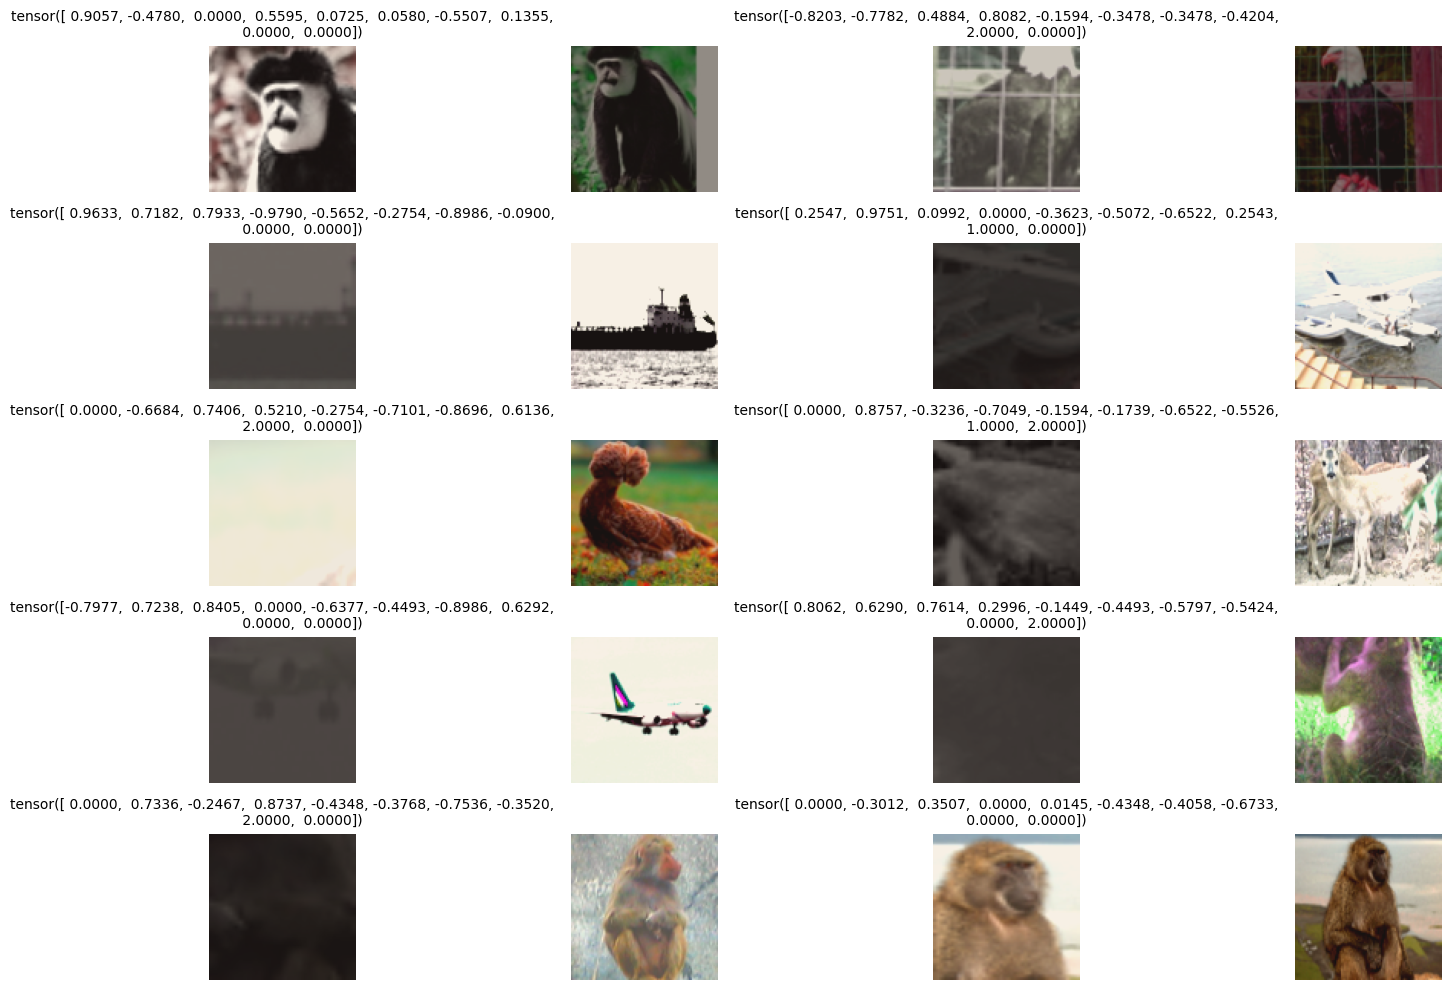

Epoch: 1312 - Next @ 257347:   0%|          | 0/2000 [00:43<?, ?it/s, Step: 257258]

Error at step 257258: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1323 - Next @ 259503:   1%|          | 11/2000 [11:35<35:51:01, 64.89s/it, Step: 259399]

Error at step 259399: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1336 - Next @ 262051:   1%|          | 24/2000 [23:04<28:21:46, 51.67s/it, Step: 261998]

Error at step 261998: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1348 - Next @ 264403:   2%|▏         | 36/2000 [33:24<28:06:21, 51.52s/it, Step: 264333]

Error at step 264333: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1357 - Next @ 266167:   2%|▏         | 45/2000 [42:24<29:32:47, 54.41s/it, Step: 266104]

Error at step 266104: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1368 - Next @ 268323:   3%|▎         | 56/2000 [51:58<28:05:13, 52.01s/it, Step: 268268]

Error at step 268268: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1379 - Next @ 270479:   3%|▎         | 67/2000 [1:00:57<28:16:14, 52.65s/it, Step: 270288]

Error at step 270288: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1391 - Next @ 272831:   4%|▍         | 79/2000 [1:13:04<28:57:46, 54.28s/it, Step: 272744]

Error at step 272744: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1403 - Next @ 275183:   5%|▍         | 91/2000 [1:23:41<27:42:28, 52.25s/it, Step: 275120]

Error at step 275120: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1414 - Next @ 277339:   5%|▌         | 102/2000 [1:34:04<31:33:34, 59.86s/it, Step: 277181]

Error at step 277181: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1429 - Next @ 280279:   6%|▌         | 117/2000 [1:47:25<28:04:44, 53.68s/it, Step: 280177]

Error at step 280177: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1443 - Next @ 283023:   7%|▋         | 131/2000 [2:00:39<33:15:39, 64.07s/it, Step: 282873]

Error at step 282873: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1463 - Next @ 286943:   8%|▊         | 151/2000 [2:18:24<26:31:22, 51.64s/it, Step: 286895]

Error at step 286895: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1464 - Next @ 287139:   8%|▊         | 152/2000 [2:18:51<26:31:41, 51.68s/it, Step: 286994]

Error at step 286994: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1474 - Next @ 289099:   8%|▊         | 162/2000 [2:28:49<30:19:09, 59.38s/it, Step: 288952]

Error at step 288952: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1488 - Next @ 291843:   9%|▉         | 176/2000 [2:40:49<26:07:06, 51.55s/it, Step: 291679]

Error at step 291679: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1501 - Next @ 294391:   9%|▉         | 189/2000 [2:53:49<37:24:53, 74.37s/it, Step: 294351]

Error at step 294351: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1512 - Next @ 296547:  10%|█         | 200/2000 [3:02:55<25:53:59, 51.80s/it, Step: 296420]

Error at step 296420: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1529 - Next @ 299879:  11%|█         | 217/2000 [3:17:25<25:23:28, 51.27s/it, Step: 299725]

Error at step 299725: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1542 - Next @ 302427:  12%|█▏        | 230/2000 [3:30:40<25:53:44, 52.67s/it, Step: 302410]

Error at step 302410: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1557 - Next @ 305367:  12%|█▏        | 245/2000 [3:43:41<26:58:37, 55.34s/it, Step: 305235]

Error at step 305235: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1576 - Next @ 309091:  13%|█▎        | 264/2000 [4:02:30<26:15:31, 54.45s/it, Step: 308985]

Error at step 308985: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1578 - Next @ 309483:  13%|█▎        | 266/2000 [4:04:10<26:00:45, 54.01s/it, Step: 309347]

Error at step 309347: The total norm of order 2.0 for gradients from `parameters` is non-finite, so it cannot be clipped. To disable this error and scale the gradients by the non-finite norm anyway, set `error_if_nonfinite=False`


Epoch: 1583 - Next @ 310463:  14%|█▎        | 271/2000 [4:08:48<26:22:30, 54.92s/it, Step: 310343]

In [ ]:
start_training(args)

In [ ]:
import os
import tqdm as tqdm
def get_dir_size_mb(path: str) -> float:
    """
    Calculate the total size of files in `path` (including all subdirectories),
    and return the result in megabytes.
    """
    total_bytes = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for fname in filenames:
            fpath = os.path.join(dirpath, fname)
            # skip broken symlinks
            if not os.path.islink(fpath):
                try:
                    total_bytes += os.path.getsize(fpath)
                except OSError:
                    # skip files we can’t access
                    pass
    # convert bytes to megabytes
    return total_bytes / (1024 * 1024)

# Example usage:
folder = "/notebooks/3DIEBench/3DIEBench"
size_mb = get_dir_size_mb(folder)
print(f"Total size of '{folder}': {size_mb:.2f} MB")


Total size of '/notebooks/3DIEBench/3DIEBench': 18682.02 MB


In [ ]:
os.mkdir("/storage/3DIEBench")

KeyboardInterrupt: 

In [ ]:
import os
os.listdir("/storage/3DIEBench")

['3DIEBench']

In [ ]:
from tqdm import tqdm

In [ ]:
import os
import shutil
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def scan_and_sync_multithread(src_root: str, dst_root: str, num_scanner_threads: int = 8, num_copy_threads: int = 8):
    """
    1) Walk src_root once, collect a list of ALL directories (all_dirs).
    2) Use a ThreadPoolExecutor of size `num_scanner_threads` to process each directory in parallel:
         • Compute its destination‐dir path => append to `dirs_to_create`.
         • For every file in that source directory, if it doesn't exist in dst, append (src, dst) to `file_tasks`.
    3) Create all missing directories (single‐threaded).
    4) Copy all missing files with another ThreadPoolExecutor of size `num_copy_threads`, showing tqdm.
    """

    # --- STEP 1: collect a flat list of all source‐directories ---
    all_dirs = []
    k = len(os.listdir(src_root))
    for d, subdirs, _ in tqdm(os.walk(src_root), total=k):
        all_dirs.append(d)

    # Shared lists (protected by `lock`) where we accumulate:
    dirs_to_create = []
    file_tasks = []
    lock = threading.Lock()

    # --- STEP 2: process each directory in parallel threads ---
    def process_one_dir(current_dir):
        # 2a) compute its corresponding dst_dir
        rel_path = os.path.relpath(current_dir, src_root)
        if rel_path == ".":
            dst_dir = dst_root
        else:
            dst_dir = os.path.join(dst_root, rel_path)

        # Safely append this directory to dirs_to_create
        with lock:
            dirs_to_create.append(dst_dir)

        # 2b) scan all files in current_dir
        # (We use os.listdir() since we know `current_dir` is a directory from the walk.)
        try:
            for fname in os.listdir(current_dir):
                src_file = os.path.join(current_dir, fname)
                # Only consider regular files (skip subdirs here)
                if not os.path.isfile(src_file):
                    continue

                dst_file = os.path.join(dst_dir, fname)
                if not os.path.exists(dst_file):
                    # If missing in dst, schedule for copying
                    with lock:
                        file_tasks.append((src_file, dst_file))
        except PermissionError:
            # If you hit a restricted directory, just skip it.
            pass

    # Use a ThreadPoolExecutor to process directories in parallel
    with ThreadPoolExecutor(max_workers=num_scanner_threads) as scanner_pool:
        # We wrap the futures in tqdm, so you see how many directories have been processed so far.
        futures = {scanner_pool.submit(process_one_dir, d): d for d in all_dirs}
        for _ in tqdm(
            as_completed(futures),
            total=len(all_dirs),
            desc="Scanning directories",
            unit="dir"
        ):
            pass  # Just advancing tqdm; actual work is done in process_one_dir

    # --- STEP 3: create all missing directories (single‐threaded) ---
    # Using exist_ok=True means “if it’s already there, do nothing.”
    for dst_dir in dirs_to_create:
        os.makedirs(dst_dir, exist_ok=True)

    # --- STEP 4: copy files in parallel, with tqdm ---
    total_to_copy = len(file_tasks)
    if total_to_copy == 0:
        print("All files up to date—nothing left to copy.")
        return
    
    def _copy_job(task):
        src_file, dst_file = task
        # By now, dst_dir is guaranteed to exist.
        shutil.copy2(src_file, dst_file)

    with ThreadPoolExecutor(max_workers=num_copy_threads) as copy_pool:
        with tqdm(total=total_to_copy, desc="Copying files", unit="file") as copy_bar:
            # We can update tqdm inside a callback
            def _on_copy_done(fut):
                copy_bar.update(1)

            for task in file_tasks:
                future = copy_pool.submit(_copy_job, task)
                future.add_done_callback(_on_copy_done)

            # Wait for all copy‐futures to finish
            copy_pool.shutdown(wait=True)

    print(f"Done! Copied {total_to_copy} missing files.")


SRC = "/notebooks/3DIEBench/3DIEBench"
DST = "/storage/3DIEBench/3DIEBench"
scan_and_sync_multithread(SRC, DST, num_scanner_threads=7, num_copy_threads=7)


52528it [02:26, 359.45it/s]           
Copying files: 100%|██████████| 380385/380385 [07:24<00:00, 854.88file/s] 


Done! Copied 380385 missing files.


In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def verify_copied_multithread(src_root: str,
                              dst_root: str,
                              num_threads: int = 8,
                              check_size: bool = True):
    """
    Verifies (in parallel) that each file in src_root exists in dst_root—and, if check_size=True,
    that the file‐sizes match exactly.

    Args:
        src_root (str): Absolute path of the source folder tree.
        dst_root (str): Absolute path of the destination folder tree.
        num_threads (int): Number of threads in the pool for verification.
        check_size (bool): If True, also compare os.path.getsize(src_file) == os.path.getsize(dst_file).

    Returns:
        missing_files (List[str]): List of relative paths (under src_root) that are missing in dst_root.
        size_mismatches (List[str]): List of relative paths whose sizes differ (only if check_size=True).
    """

    # 1) Gather a list of all files under src_root (store their relative paths).
    all_src_files = []
    for current_dir, subdirs, filenames in os.walk(src_root):
        rel_dir = os.path.relpath(current_dir, src_root)
        for fname in filenames:
            # Build the relative path of this file (e.g. "subdirA/foo.txt")
            if rel_dir == ".":
                rel_path = fname
            else:
                rel_path = os.path.join(rel_dir, fname)
            all_src_files.append(rel_path)

    total_files = len(all_src_files)
    if total_files == 0:
        print("No files found under src_root.")
        return [], []

    # Containers for results (thread‐protected only by final collection—no locks needed if we collect via futures)
    missing = []
    mismatched = []

    # Worker that checks one relative path:
    def _check_one(rel_path):
        src_file = os.path.join(src_root, rel_path)
        dst_file = os.path.join(dst_root, rel_path)

        if not os.path.exists(dst_file):
            return ("MISSING", rel_path)

        if check_size:
            try:
                s_size = os.path.getsize(src_file)
                d_size = os.path.getsize(dst_file)
            except OSError:
                # Could not stat one of the files—treat as mismatch
                return ("MISMATCH", rel_path)

            if s_size != d_size:
                return ("MISMATCH", rel_path)

        return ("OK", rel_path)

    # 2) Spin up ThreadPoolExecutor and feed all_src_files to it, tracking progress with tqdm.
    with ThreadPoolExecutor(max_workers=num_threads) as pool:
        futures = {pool.submit(_check_one, rel): rel for rel in all_src_files}

        with tqdm(total=total_files, desc="Verifying files", unit="file") as pbar:
            for fut in as_completed(futures):
                status, rel_path = fut.result()
                if status == "MISSING":
                    missing.append(rel_path)
                elif status == "MISMATCH":
                    mismatched.append(rel_path)

                pbar.update(1)

    # 3) Return two lists: files missing entirely, and files whose sizes differ
    return missing, mismatched 
                                                                                                        

SRC = "/notebooks/3DIEBench/3DIEBench"
DST = "/storage/3DIEBench/3DIEBench"

missing_files, size_mismatches = verify_copied_multithread(
    src_root=SRC,
    dst_root=DST,
    num_threads=7,
    check_size=True
)

if not missing_files and not size_mismatches:
    print("✅ All files are present and (if checked) sizes match.")
else:
    if missing_files:
        print(f"⚠️  {len(missing_files)} files are missing in destination:")
        for rel in missing_files:
            print("   •", rel)
    if size_mismatches:
        print(f"⚠️  {len(size_mismatches)} files differ in size:")
        for rel in size_mismatches:
            print("   •", rel)


Verifying files: 100%|██████████| 5247201/5247201 [13:41<00:00, 6388.34file/s]


✅ All files are present and (if checked) sizes match.


In [ ]:
src = "/notebooks/utils/meta_data"
dst = "/storage/utils/meta_data"

os.makedirs(dst, exist_ok=True)


In [ ]:
import os
os.listdir("/storage/")

['model_1.pth', 'stl10', '3DIEBench', 'utils']

In [ ]:

shutil.copytree(src, dst)

'/storage/utils/meta_data'

In [ ]:
import os
import threading
from queue import Queue, Empty

def parallel_collect_paths(root_path: str, num_threads: int = 8):
    """
    Walk the directory tree under `root_path` in parallel, collecting:
      - all_files: a list of full paths to every file
      - all_dirs:  a list of full paths to every directory (excluding root_path)
    Finally, the caller can append root_path to all_dirs if needed.

    Args:
        root_path (str): The top directory to traverse.
        num_threads (int): How many worker threads to spawn.

    Returns:
        all_files (List[str]) : full paths of all files under root_path
        all_dirs  (List[str]) : full paths of all subdirectories under root_path
    """
    # Thread‐safe queue of directories to process
    q = Queue()
    q.put(root_path)

    # Shared lists (protected by `lock`)
    all_files = []
    all_dirs = []
    lock = threading.Lock()

    def worker():
        while True:
            try:
                dirpath = q.get_nowait()
            except Empty:
                # No more directories to process
                return

            try:
                # List all entries in this directory
                entries = os.listdir(dirpath)
            except Exception:
                # If we can’t read this directory for any reason, skip it
                q.task_done()
                continue

            for name in entries:
                full_path = os.path.join(dirpath, name)
                if os.path.isdir(full_path):
                    # Record this directory, then schedule it for further walking
                    with lock:
                        all_dirs.append(full_path)
                    q.put(full_path)
                else:
                    # It’s a file; record it
                    with lock:
                        all_files.append(full_path)

            q.task_done()

    # Spawn worker threads
    threads = []
    for _ in range(num_threads):
        t = threading.Thread(target=worker, daemon=True)
        t.start()
        threads.append(t)

    # Wait until every directory has been processed
    q.join()

    # (Optional) Join threads (they should all exit once queue is empty)
    for t in threads:
        t.join()

    return all_files, all_dirs


def delete_in_parallel(root_path: str, num_threads: int = 8):
    # 1) Gather everything in parallel
    files_list, dirs_list = parallel_collect_paths(root_path, num_threads=num_threads)
    # Include the root itself as the final directory to remove
    dirs_list.append(root_path)

    # 2) Delete all files in parallel
    def _remove_file(path):
        try:
            os.remove(path)
        except Exception as e:
            print(f"Failed to remove file {path!r}: {e}")

    if files_list:
        print(f"Deleting {len(files_list)} files ...")
        with ThreadPoolExecutor(max_workers=num_threads) as pool:
            list(pool.map(_remove_file, files_list))

    # 3) Delete all directories in parallel (deepest first)
    # Sort by depth: deeper dirs (more separators) first
    dirs_sorted = sorted(dirs_list, key=lambda p: -p.count(os.sep))

    def _remove_dir(path):
        try:
            os.rmdir(path)
        except Exception as e:
            print(f"Failed to remove directory {path!r}: {e}")

    if dirs_sorted:
        print(f"Deleting {len(dirs_sorted)} directories ...")
        with ThreadPoolExecutor(max_workers=num_threads) as pool:
            list(pool.map(_remove_dir, dirs_sorted))

    print(f"✅ Finished deleting everything under {root_path} (including {root_path} itself).")

# Example usage:
ROOT = "/notebooks/.Trash-0/files/3DIEBench/3DIEBench"
delete_in_parallel(ROOT, num_threads=7)


Deleting 2812611 files ...
Deleting 28164 directories ...
✅ Finished deleting everything under /notebooks/.Trash-0/files/3DIEBench/3DIEBench (including /notebooks/.Trash-0/files/3DIEBench/3DIEBench itself).


In [ ]:
import os
import threading
from queue import Queue, Empty

def get_dir_size_multithread(root_path: str, num_threads: int = 8) -> int:
    """
    Computes the total size (in bytes) of all regular files under `root_path` (including all subdirectories),
    using multiple threads to traverse the tree in parallel.

    Args:
        root_path (str): The directory whose total size you want to calculate.
                         If it does not exist or is not a directory, the function returns 0.
        num_threads (int): Number of worker threads to spawn for parallel traversal.

    Returns:
        int: Total size in bytes of all non‐symlink files under `root_path`.
             Symlinks are skipped to avoid potential cycles.
    """
    if not os.path.isdir(root_path):
        return 0

    # Thread‐safe queue of directories to process
    q = Queue()
    q.put(root_path)

    total_size = 0
    size_lock = threading.Lock()

    def worker():
        nonlocal total_size
        while True:
            try:
                dirpath = q.get_nowait()
            except Empty:
                return

            try:
                for name in os.listdir(dirpath):
                    full_path = os.path.join(dirpath, name)

                    # Skip symlinks entirely (avoids cycles or double‐counting)
                    if os.path.islink(full_path):
                        continue

                    if os.path.isdir(full_path):
                        # Enqueue subdirectory for further processing
                        q.put(full_path)
                    elif os.path.isfile(full_path):
                        try:
                            size = os.path.getsize(full_path)
                        except OSError:
                            # Could not stat this file; skip it
                            continue
                        with size_lock:
                            total_size += size
            except Exception:
                # If we cannot list dirpath (permission error, etc.), skip it
                pass
            finally:
                q.task_done()

    # Spawn worker threads
    threads = []
    for _ in range(num_threads):
        t = threading.Thread(target=worker, daemon=True)
        t.start()
        threads.append(t)

    # Block until all directories in the queue have been processed
    q.join()

    # Ensure all threads have exited
    for t in threads:
        t.join()

    return total_size

ROOT ="/notebooks/"
size_in_bytes = get_dir_size_multithread(ROOT, num_threads=8)
print(f"Total size of '{ROOT}': {size_in_bytes:,} bytes ({size_in_bytes/1024/1024:.2f} MiB)")


Total size of '/notebooks/': 12,956,444,882 bytes (12356.23 MiB)


# End